<a name="top" id="top"></a>

<div align="center">
    <h1>Sensor placement and fault diagnosis in water distribution netwroks</h1>
    <a href="https://github.com/anurag-r20">Anurag Ramesh</a>
    <br>
    <i>Graduate Research Assistant</i>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Universities Space Research Association</i>
    <br>
    <i>NASA QuAIL</i>
    <br>
    <br>
   <a href="https://colab.research.google.com/github.com/anurag-r20/WDN_Sensor_Placement/WDN_Sensor_Placement.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

## Sensor Placement in Water Distribution Networks (WDN)

In this notebook, we formulate an optimization problem to identify the optimal placement of pressure sensors in a Water Distribution Network (WDN). The WDN is represented on a constrained graph $G(V,E)$, where $V$ is the set of vertices and $E$ is the set of edges.

We consider four different formulations of the optimization problem, including Mixed Integer Programming (MIP), Mixed Integer Quadratic Programming (MIQP), and Quadratic Unconstrained Binary Optimization (QUBO). The optimization problem is solved using three different solvers: Gurobi, Simulated Annealing, and D-Wave's implementation of Quantum Annealing via **[neal](https://github.com/dwavesystems/dwave-neal)**.

Additionally, we leverage D-Wave's package **[dwavebinarycsp](https://github.com/dwavesystems/dwavebinarycsp)** to translate constraint satisfaction problems into QUBOs. For Groebner basis computations, we use **[Sympy](https://www.sympy.org/)** for symbolic computation in Python and **[Networkx](https://networkx.github.io/)** for network models and graphs.

In [732]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's install dimod, neal, and pyomo
if IN_COLAB:
    !pip install -q pyomo
    !pip install dimod
    !pip install dwave-neal

In [733]:
# Import the Pyomo library, which can be installed via pip, conda or from Github https://github.com/Pyomo/pyomo
import pyomo.environ as pyo
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import pandas as pd
import os
import time
import operator
# Import networkx for graph problems
import networkx as nx
from matplotlib.lines import Line2D

In [734]:
def WDN_network_nodes(city):

    "This function is used to import the node data of the water distribution network (WDN) (using pandas) of the relevant city."

    # Path to data file (local)
    if city == "Apulian":
        file_path = '/mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Nodes.txt'
    elif city == "Fossolo":
        file_path = '/mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Fossolo_WDN/Fossolo_WDN_Nodes.txt'
    else:
        print(f"Error: Unknown city {city}.")
        return None, None, None

    if not os.path.exists(file_path):
        print(f"Error: The file {file_path} does not exist.")
        return None, None, None

    # Debugging: Print file path
    print(f"Reading data from: {file_path}")

    # Importing data
    nodes_df = pd.read_csv(file_path, skiprows=1, names=["Node", "X", "Y"]) # nodes dataframe

    # Strip spaces
    nodes_df['Node'] = nodes_df['Node'].str.strip()

    # Convert the data to a dictionary with node names as keys and (x, y) tuples as values.
    nodes = {row['Node']: (float(row['X']), float(row['Y'])) for i, row in nodes_df.iterrows()}

    return nodes


In [735]:
city = "Apulian"
print(WDN_network_nodes(city))

Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Nodes.txt
{'J-1': (1597.24, 1180.0), 'J-2': (1432.13, 1340.0), 'J-3': (745.9, 1346.0), 'J-4': (921.33, 1124.0), 'J-5': (1344.42, 1015.0), 'J-6': (1086.44, 912.0), 'J-7': (931.65, 804.0), 'J-8': (828.45, 752.0), 'J-9': (493.07, 1279.0), 'J-10': (59.66, 1242.0), 'J-11': (400.2, 1180.0), 'J-12': (312.48, 917.0), 'J-13': (54.5, 1015.0), 'J-14': (1076.12, 443.0), 'J-15': (1168.99, 448.0), 'J-16': (1344.42, 494.0), 'J-17': (1690.12, 592.0), 'J-18': (1514.69, 799.0), 'J-19': (1772.67, 861.0), 'J-20': (1349.58, 25.0), 'J-21': (1850.07, 283.0), 'J-22': (487.91, 659.0), 'J-23': (2020.34, 489.0), 'T-1': (1860.39, 1181.0)}


In [736]:
def WDN_network_edges(city):

    "This function is used to import the edge data of the water distribution network (WDN) (using pandas) of the relevant city."

    # Path to data file (local)
    if city == "Apulian":
        file_path = '/mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Edges.txt'
    elif city == "Fossolo":
        file_path = '/mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Fossolo_WDN/Fossolo_WDN_Edges.txt'
    else:
        print(f"Error: Unknown city {city}.")
        return None, None, None

    if not os.path.exists(file_path):
        print(f"Error: The file {file_path} does not exist.")
        return None, None, None

    # Debugging: Print file path
    print(f"Reading data from: {file_path}")

    # Importing data
    edges_df = pd.read_csv(file_path, skiprows=1, names=["Node1", "Node2"]) # edges dataframe

    # Strip spaces
    edges_df['Node1'] = edges_df['Node1'].str.strip()
    edges_df['Node2'] = edges_df['Node2'].str.strip()

    # Convert the data to a dictionary with node names as keys and (x, y) tuples as values.
    edges = {((row['Node1']), (row['Node2'])) for i, row in edges_df.iterrows()}

    return edges

In [737]:
city = "Apulian"
print(WDN_network_edges(city))

Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Edges.txt
{('J-5', 'J-18'), ('J-1', 'J-19'), ('J-13', 'J-22'), ('J-14', 'J-15'), ('J-8', 'J-14'), ('J-9', 'J-10'), ('J-7', 'J-15'), ('J-12', 'J-13'), ('J-11', 'J-12'), ('J-1', 'J-5'), ('J-17', 'J-21'), ('J-2', 'J-4'), ('J-6', 'J-16'), ('J-3', 'J-4'), ('J-17', 'J-18'), ('J-10', 'J-11'), ('J-20', 'J-21'), ('J-2', 'J-3'), ('J-15', 'J-16'), ('J-19', 'J-23'), ('J-4', 'J-6'), ('J-16', 'J-17'), ('J-10', 'J-13'), ('J-6', 'J-7'), ('J-2', 'J-1'), ('J-21', 'J-23'), ('J-5', 'J-6'), ('J-11', 'J-9'), ('J-9', 'J-3'), ('T-1', 'J-1'), ('J-18', 'J-19'), ('J-20', 'J-14'), ('J-8', 'J-22'), ('J-7', 'J-8')}


In [738]:
def WDN_network_water_consumption(city):

    "This function is used to import the water consumption data for the nodes in the water distribution network (WDN) (using pandas) of the relevant city."

    # Path to data file (local)
    if city == "Apulian":
        file_path = '/mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Water_Consumption.txt'
    elif city == "Fossolo":
        file_path = '/mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Fossolo_WDN/Fossolo_WDN_Water_Consumption.txt'
    else:
        print(f"Error: Unknown city {city}.")
        return None, None, None

    if not os.path.exists(file_path):
        print(f"Error: The file {file_path} does not exist.")
        return None, None, None

    # Debugging: Print file path
    print(f"Reading data from: {file_path}")

    # Importing data
    water_consumption_df = pd.read_csv(file_path, skiprows=1, names=["Node", "Consumption"]) # water consumption dataframe

    # Strip spaces
    water_consumption_df['Node'] = water_consumption_df['Node'].str.strip()


    # Convert the data to a dictionary with node names as keys and (x, y) tuples as values.
    water_consumption = {row['Node']: (float(row['Consumption'])) for i, row in water_consumption_df.iterrows()}

    return water_consumption


In [739]:
city = "Apulian"
WC = WDN_network_water_consumption(city)
print("Water consumption: \n", WC)

Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Water_Consumption.txt
Water consumption: 
 {'J-1': 10.863, 'J-2': 117.034, 'J-3': 14.947, 'J-4': 14.8, 'J-5': 10.133, 'J-6': 13.35, 'J-7': 9.114, 'J-8': 10.51, 'J-9': 12.182, 'J-10': 14.579, 'J-11': 9.007, 'J-12': 7.575, 'J-13': 15.2, 'J-14': 13.55, 'J-15': 9.226, 'J-16': 11.2, 'J-17': 11.469, 'J-18': 10.818, 'J-19': 14.675, 'J-20': 13.318, 'J-21': 14.631, 'J-22': 12.012, 'J-23': 10.326, 'T-1': 10.863}


In [740]:
def Construct_Graph(city):

    "This function is used to construct a WDN graph G of the water distribution network using the node and edge data imported previously."

    coords = WDN_network_nodes(city)
    edges = WDN_network_edges(city)

    if coords is None or edges is None:
        return None
    
    G = nx.Graph()

    # Defining Nodes in their coordinates
    for node, coord in coords.items():
        G.add_node(node, pos=coord)

    # Add edges
    G.add_edges_from(edges)
    
    return G

In [741]:
city = "Apulian"
G = Construct_Graph(city)
print(G.nodes())

Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Nodes.txt
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Edges.txt
['J-1', 'J-2', 'J-3', 'J-4', 'J-5', 'J-6', 'J-7', 'J-8', 'J-9', 'J-10', 'J-11', 'J-12', 'J-13', 'J-14', 'J-15', 'J-16', 'J-17', 'J-18', 'J-19', 'J-20', 'J-21', 'J-22', 'J-23', 'T-1']


In [742]:
def centrality(G, water_consumption):

    "This function is used to calculate centrality metrics for a given city's WDN graph G and water consumption data imported previously"
    
    # Calculating edge betweenness centrality
    edge_betweenness = nx.edge_betweenness_centrality(G)

    # Calculate degree centrality
    degree_centrality = nx.degree_centrality(G)

    # Edge betweenness centrality as weights
    for (u, v, d) in G.edges(data=True):
        d['weight'] = edge_betweenness[(u, v)]

    # Define the weights C and D
    C = 1.0
    D = 1.0

    def compute_normalized_demand(water_consumption):        
        max_demand = max(water_consumption.items(), key=operator.itemgetter(1))[1]
        return {node: val / max_demand for node, val in water_consumption.items()}

    normalized_demand = compute_normalized_demand(water_consumption)

    # Debugging: print the node names in the graph
    print("Graph nodes:", list(G.nodes()))
    
    # Debugging: print the keys in normalized_demand
    print("Normalized demand keys:", list(normalized_demand.keys()))

    # Vertex cost function:
    vertex_cost = {}
    for node in G.nodes():
        f_i = normalized_demand.get(node, None)   # function of the water need at each node i
        if f_i is None:
            print(f"Node {node} not found in normalized_demand")
            continue
        g_i = degree_centrality[node]  # node weights
        vertex_cost[node] = C * f_i + D * g_i
    
    return vertex_cost, edge_betweenness


In [743]:
def plot_WDN(city):

    "This function is used to plot the graph of the city's WDN"

    G = Construct_Graph(city)
    if G is None:
        print(f"Graph could not be constructed for {city}.")
        return

    water_consumption = WDN_network_water_consumption(city)

    VC, EB = centrality(G, water_consumption)

    pos = nx.get_node_attributes(G, 'pos')
    
    if not pos:
        print("Error: Position dictionary is empty.")
        return

    print("Position Dictionary:", pos)

    # Create plot
    plt.figure(figsize=(16, 8))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    # Round off edge and node labels to two decimals for the plot
    edge_labels_rounded = {k: round(v, 2) for k, v in EB.items()}
    node_labels_rounded = {k: round(v, 2) for k, v in VC.items()}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_rounded, label_pos=0.5, font_size=6, verticalalignment='bottom')
    nx.draw_networkx_labels(G, pos, labels=node_labels_rounded, font_size=8, font_color='black')

    # Add legend
    blue_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=10, label='Potential nodes for sensor placement')
    plt.legend(handles=[blue_patch], loc='best')

    plt.title(f"Water Distribution Network - {city}")
    plt.show()

Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Nodes.txt
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Edges.txt
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Water_Consumption.txt
Graph nodes: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5', 'J-6', 'J-7', 'J-8', 'J-9', 'J-10', 'J-11', 'J-12', 'J-13', 'J-14', 'J-15', 'J-16', 'J-17', 'J-18', 'J-19', 'J-20', 'J-21', 'J-22', 'J-23', 'T-1']
Normalized demand keys: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5', 'J-6', 'J-7', 'J-8', 'J-9', 'J-10', 'J-11', 'J-12', 'J-13', 'J-14', 'J-15', 'J-16', 'J-17', 'J-18', 'J-19', 'J-20', 'J-21', 'J-22', 'J-23', 'T-1']
Position Dictionary: {'J-1': (1597.24, 1180.0), 'J-2': (1432.13, 1340.0), 'J-3': (745.9, 1346.0), 'J-4': (921.33, 1124.0), 'J-5': (1344.42, 1015.0), 'J-6': (10

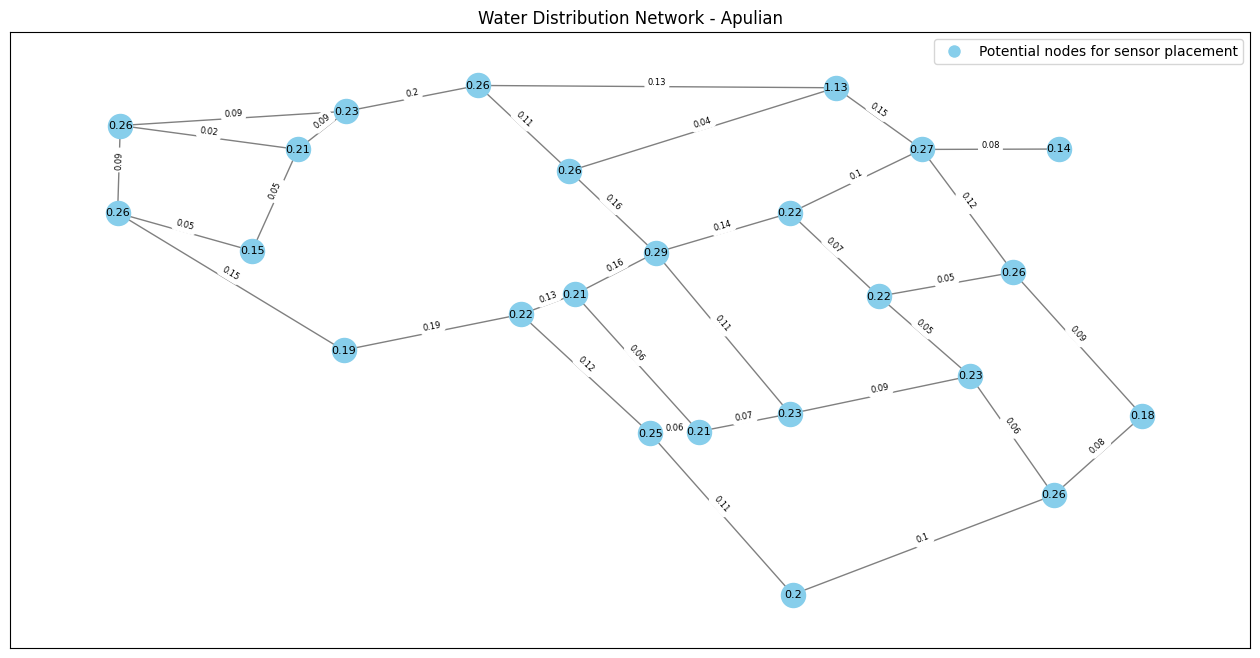

In [744]:
city = "Apulian"
plot_WDN(city)

The solution to this graph problem is explored using different reformulations of the problem.

First, we formulate the graph optimization problem as a Mixed Integer Program (MIP) (Speziali et al. (2021)):


$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j}) \\
    \textrm{s.t.} & \sum_{i \in V} x_{i} = s \\
    & x_{i} \in \{0,1 \}^{n}
\end{array}
$$

Here, $c_{i}$ represents the cost of the $i^{th}$ node, $w_{ij}$ represents the weight corresponding to the edge between nodes $i$ and $j$, and $x_{i} \in \{0, 1\}^{n}$ is a binary decision variable that indicates whether a sensor is placed at the $i^{th}$ node. $s$ is the predefined total number of sensors.

Next, the Quadratic Unconstrained Binary Optimzation (QUBO) formulation of the graph problem is explored. Consider the MIP model from before:
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j}) \\
    \textrm{s.t.} & \sum_{i \in V} x_{i} = s \\
    & x_{i} \in \{0,1 \}^{n}
\end{array}
$$
To implement the problem as a QUBO, the constraint should be lifted up into the objective function such that the problem becomes unconstrained. This is performed as follows:
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} (w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j})) + \rho(\sum_{i \in V} x_{i} - s)^2 \\
\end{array}
$$
where $\rho$ is a scalar penalty term. Further simplification leads to
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} w_{ij} - \sum_{(i, j) \in E} w_{ij}x_{j} - \sum_{(i, j) \in E} w_{ij}x_{i} + \sum_{(i, j) \in E} w_{ij}x_{i}x_{j} + \rho\sum_{i \in V} x_{i}^2 - 2\rho\sum_{i \in V} x_{i}s + \rho s^2 \\
\end{array}
$$
Since, $x_{i}$ is a binary variable, we can write $x_{i}$ as $x_{i}^2$. Taking this into account, the problem now becomes: 
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i}^2 + \sum_{(i, j) \in E}w_{ij} - \sum_{(i, j) \in E} w_{ij}x_{j}^2 - \sum_{(i, j) \in E} w_{ij}x_{i}^2 + \sum_{(i, j) \in E} w_{ij}x_{i}x_{j} + \rho\sum_{i \in V} x_{i}^2 - 2\rho\sum_{i \in V} x_{i}^2s + \rho s^2 \\
\end{array}
$$
Performing some algebraic manipulations, we have our QUBO problem.
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} \left( \sum_{i \in V} (c_i + \rho - 2\rho s - w_{ij})x_i^2 + \sum_{(i,j) \in E} w_{ij}x_i x_j + \rho s^2 + \sum_{(i,j) \in E}{w_{ij}} \right) \\
\end{array}
$$
where $s$ is the total number of sensors that is predefined.

In [745]:
def create_model(city):  # Adding problem_type as a parameter

    "This function is used to initialize a pyomo model and relevant model parameters for finding the optmial sensor placment for a city's WDN graph G"

    G = Construct_Graph(city)

    if G is None:
        print(f"{city} does not exist.")
        return None

    water_consumption = WDN_network_water_consumption(city)  # calling water consumption data

    VC, EB = centrality(G, water_consumption)  # Calling centrality measures

    # Create a pyomo model
    model = pyo.ConcreteModel()

    # Define pyomo sets for graph G
    nodes = list(G.nodes())
    edges = list(G.edges())
    model.nodes = pyo.Set(initialize=nodes)
    model.edges = pyo.Set(initialize=edges, dimen=2)

    # Parameters
    demand = water_consumption
    model.demand = pyo.Param(model.nodes, initialize=demand, mutable=True)
    model.c = pyo.Param(model.nodes, initialize=VC, mutable=True)  # vertex cost
    model.w = pyo.Param(model.edges, initialize=EB, mutable=True)  # edge_betweenness for edge weights

    # Binary decision variable
    model.x = pyo.Var(model.nodes, within=pyo.Binary)

    return model

In [746]:
# Mixed Integer Program model (MIP)
    
def MIQP(city, s):

    "This function generates the MIP model for the given problem"

    model = create_model(city)
    if model is None:
        return None
    
    # Define objective function
    def objective_rule(model):
        return sum(model.c[i] * model.x[i] for i in model.nodes) + \
                sum(model.w[(i, j)] * (1 - model.x[i] - model.x[j] + model.x[i] * model.x[j]) for (i, j) in model.edges)

    model.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

    # Constraints
    def sensor_constraint_rule(model):
        return sum(model.x[i] for i in model.nodes) == s

    model.sensor_constraint = pyo.Constraint(rule=sensor_constraint_rule)

    return model

In [747]:
# Quadratic Unconstrained Binary Optimization model (QUBO)

def QUBO(city, s, rho):

    "This function generated the QUBO model for the given problem"

    model = create_model(city)
    if model is None:
        return None

    # Define objective function 
    def objective_rule(model):
        term1 = sum(model.c[i] * model.x[i] for i in model.nodes)
        term2 = sum(model.w[(i, j)] * (1 - model.x[i]) * (1 - model.x[j]) for (i, j) in model.edges)
        term3 = rho * (sum(model.x[i] for i in model.nodes) - s) ** 2
        return term1 + term2 + term3

    model.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

    return model

    # No constraints for QUBO


In [793]:
# Select your city, model and number of sensors:
city = "Apulian"
s = 10
rho = 1 # Constant for penalty term for QUBO
model_MIQP = MIQP(city, s)
model_QUBO = QUBO(city, s, rho)

Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Nodes.txt
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Edges.txt
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Water_Consumption.txt
Graph nodes: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5', 'J-6', 'J-7', 'J-8', 'J-9', 'J-10', 'J-11', 'J-12', 'J-13', 'J-14', 'J-15', 'J-16', 'J-17', 'J-18', 'J-19', 'J-20', 'J-21', 'J-22', 'J-23', 'T-1']
Normalized demand keys: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5', 'J-6', 'J-7', 'J-8', 'J-9', 'J-10', 'J-11', 'J-12', 'J-13', 'J-14', 'J-15', 'J-16', 'J-17', 'J-18', 'J-19', 'J-20', 'J-21', 'J-22', 'J-23', 'T-1']
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Nodes.txt
Reading data from

In [794]:
# Solve
solver = pyo.SolverFactory('gurobi', solver_io='python')
results_MIQP = solver.solve(model_MIQP, tee=True) # MIP formulation result

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 24 columns and 24 nonzeros
Model fingerprint: 0xe6e61ebc
Model has 34 quadratic objective terms
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 8e-01]
  QObjective range [4e-02, 4e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 3.8099100
Presolve time: 0.05s
Presolved: 35 rows, 58 columns, 126 nonzeros
Variable types: 0 continuous, 58 integer (58 binary)

Root relaxation: objective 2.565655e+00, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

In [795]:
results_QUBO = solver.solve(model_QUBO, tee=True) # QUBO formulation result

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 0 rows, 24 columns and 0 nonzeros
Model fingerprint: 0x831eea1f
Model has 300 quadratic objective terms
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 103.4021739


Found heuristic solution: objective 2.5656552
Presolve time: 0.01s
Presolved: 276 rows, 300 columns, 828 nonzeros
Variable types: 0 continuous, 300 integer (300 binary)

Root relaxation: objective -1.248497e+02, 34 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -124.84965    0   24    2.56566 -124.84965  4966%     -    0s
     0     0  -43.56478    0  122    2.56566  -43.56478  1798%     -    0s
     0     0  -30.13127    0  197    2.56566  -30.13127  1274%     -    0s
     0     0  -30.12610    0  197    2.56566  -30.12610  1274%     -    0s
     0     2  -30.12610    0  197    2.56566  -30.12610  1274%     -    0s
  1919  1057   -0.31250   17  266    2.56566  -12.08330   571%  62.5    5s
  1948  1085   -4.23850   15  223    2.56566   -4.89836   291%  67.3   10s
  2828  1212   -1.85745   19  189    2.56566   -3.14139   222%  8

In [797]:
# Print results for MIP

for node in model_MIQP.nodes:
    print(f"Node {node}: Sensor placed = {pyo.value(model_MIQP.x[node])}")

sensor_placement_MIQP = {node: pyo.value(model_MIQP.x[node]) for node in model_MIQP.nodes}

Node J-1: Sensor placed = 1.0
Node J-2: Sensor placed = -0.0
Node J-3: Sensor placed = 1.0
Node J-4: Sensor placed = 0.0
Node J-5: Sensor placed = 0.0
Node J-6: Sensor placed = 1.0
Node J-7: Sensor placed = 0.0
Node J-8: Sensor placed = 1.0
Node J-9: Sensor placed = 0.0
Node J-10: Sensor placed = -0.0
Node J-11: Sensor placed = 1.0
Node J-12: Sensor placed = 0.0
Node J-13: Sensor placed = 1.0
Node J-14: Sensor placed = 0.0
Node J-15: Sensor placed = 1.0
Node J-16: Sensor placed = 0.0
Node J-17: Sensor placed = 1.0
Node J-18: Sensor placed = -0.0
Node J-19: Sensor placed = -0.0
Node J-20: Sensor placed = 1.0
Node J-21: Sensor placed = 0.0
Node J-22: Sensor placed = 0.0
Node J-23: Sensor placed = 1.0
Node T-1: Sensor placed = -0.0


In [798]:
# Print results for QUBO

for node in model_QUBO.nodes:
    print(f"Node {node}: Sensor placed = {pyo.value(model_QUBO.x[node])}")

sensor_placement_QUBO = {node: pyo.value(model_QUBO.x[node]) for node in model_QUBO.nodes}

Node J-1: Sensor placed = 1.0
Node J-2: Sensor placed = 0.0
Node J-3: Sensor placed = 1.0
Node J-4: Sensor placed = 0.0
Node J-5: Sensor placed = 0.0
Node J-6: Sensor placed = 1.0
Node J-7: Sensor placed = 0.0
Node J-8: Sensor placed = 1.0
Node J-9: Sensor placed = 0.0
Node J-10: Sensor placed = 0.0
Node J-11: Sensor placed = 1.0
Node J-12: Sensor placed = 0.0
Node J-13: Sensor placed = 1.0
Node J-14: Sensor placed = 0.0
Node J-15: Sensor placed = 1.0
Node J-16: Sensor placed = 0.0
Node J-17: Sensor placed = 1.0
Node J-18: Sensor placed = 0.0
Node J-19: Sensor placed = 0.0
Node J-20: Sensor placed = 1.0
Node J-21: Sensor placed = 0.0
Node J-22: Sensor placed = 0.0
Node J-23: Sensor placed = 1.0
Node T-1: Sensor placed = 0.0


In [799]:
def plot_sensor_placement(city, sensor_placement, subplot_index, title):

    "This function provides the base structure for plotting a city's WDN and the optmial sensor placement"

    G = Construct_Graph(city)

    if G is None:
        print(f"Graph could not be constructed for {city}.")
        return

    # Select water consumption data
    water_consumption = WDN_network_water_consumption(city)

    # Centrality measures
    VC, EB = centrality(G, water_consumption)

    pos = nx.get_node_attributes(G, 'pos')

    # Create plot
    plt.subplot(2, 1, subplot_index)
    
    # Determine node colors based on sensor placement
    node_colors = ['red' if sensor_placement.get(node, 0) == 1 else 'skyblue' for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    #nx.draw_networkx_labels(G, pos, font_size=6, font_color='black')

    # Round off edge and node labels to two decimals for the plot
    edge_labels_rounded = {k: round(v, 2) for k, v in EB.items()}
    node_labels_rounded = {k: round(v, 2) for k, v in VC.items()}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_rounded, label_pos=0.5, font_size=6, verticalalignment='bottom')
    nx.draw_networkx_labels(G, pos, labels=node_labels_rounded, font_size=8, font_color='black')

    # Add legend
    red_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Sensor placed')
    blue_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=10, label='No sensor')
    plt.legend(handles=[red_patch, blue_patch], loc='best')

    plt.title(title)

In [800]:
def plot_comparison(city, sensor_placement_MIQP, sensor_placement_QUBO):

    "This function plots a city's WDN with the optimal snesor placments obtained through the MIP and QUBO formulations in a single plot"

    plt.figure(figsize=(16, 16))

    plot_sensor_placement(city, sensor_placement_MIQP, 1, 'Sensor Placement - Solution obtained through MIP formulation')
    plot_sensor_placement(city, sensor_placement_QUBO, 2, 'Sensor Placement - Solution obtained through QUBO formulation')

    plt.show()

Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Nodes.txt
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Edges.txt
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Water_Consumption.txt
Graph nodes: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5', 'J-6', 'J-7', 'J-8', 'J-9', 'J-10', 'J-11', 'J-12', 'J-13', 'J-14', 'J-15', 'J-16', 'J-17', 'J-18', 'J-19', 'J-20', 'J-21', 'J-22', 'J-23', 'T-1']
Normalized demand keys: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5', 'J-6', 'J-7', 'J-8', 'J-9', 'J-10', 'J-11', 'J-12', 'J-13', 'J-14', 'J-15', 'J-16', 'J-17', 'J-18', 'J-19', 'J-20', 'J-21', 'J-22', 'J-23', 'T-1']
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Nodes.txt
Reading data from

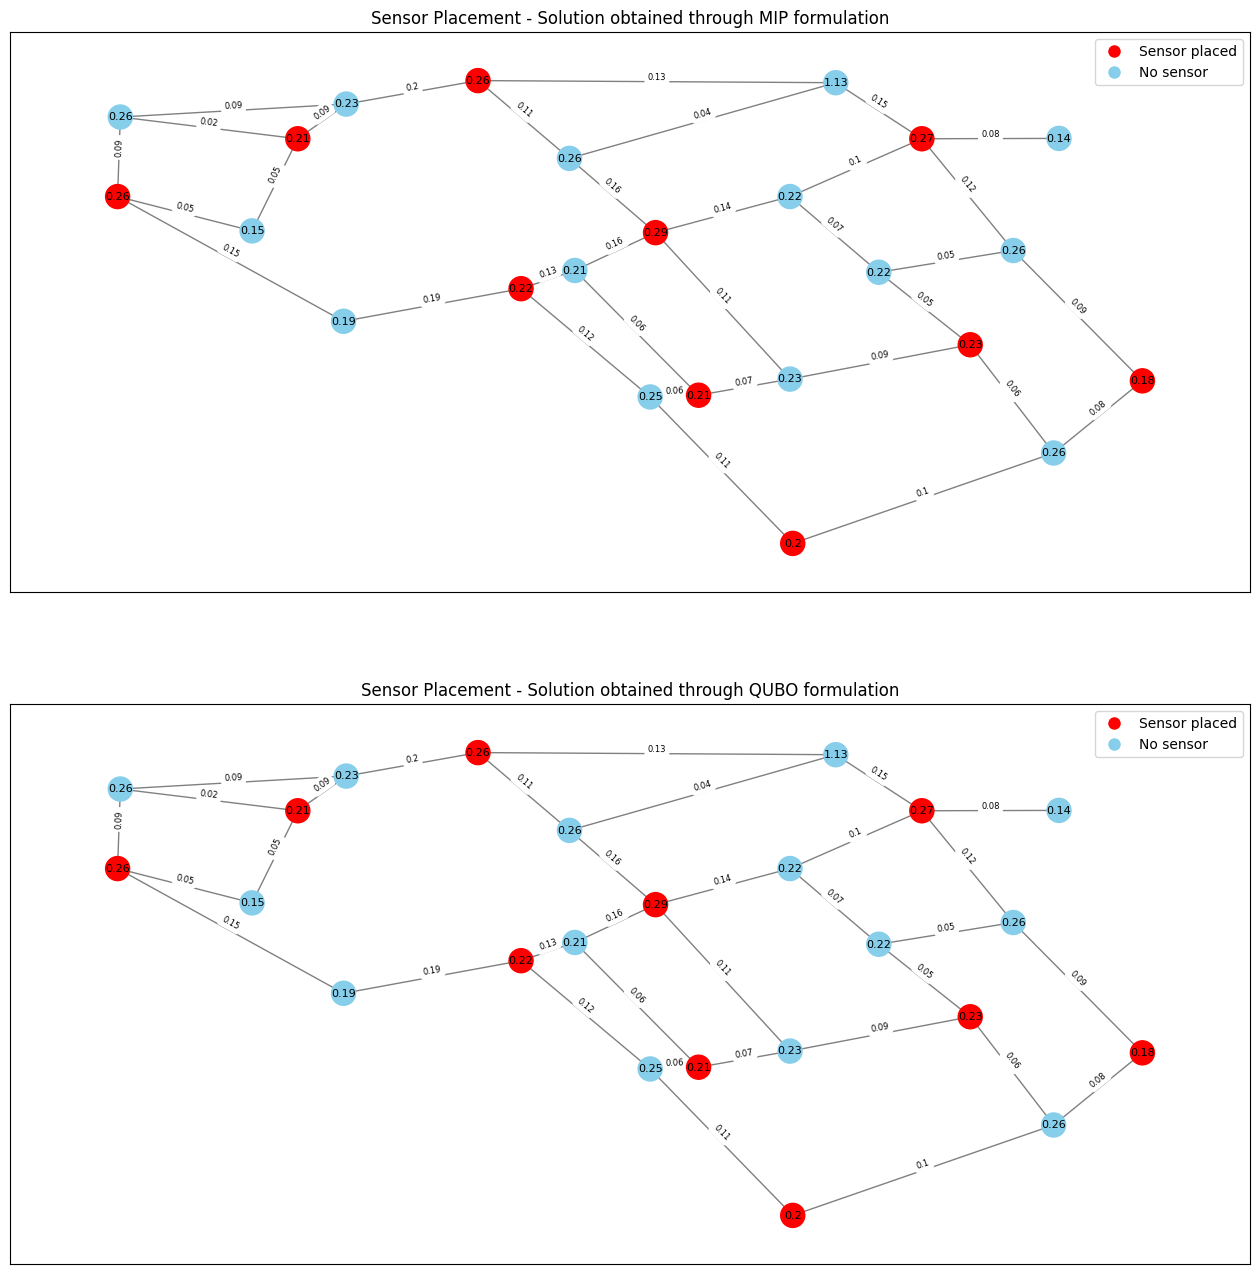

In [801]:
plot_comparison(city, sensor_placement_MIQP, sensor_placement_QUBO)

## Simulated Annealing:
 First, we build the adjacency matrix $Q$ that is obtained from the QUBO model. Remember that the QUBO problem is formulated as follows: 
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} \left( \sum_{i \in V} (c_i + \rho - 2\rho s - w_{ij})x_i^2 + \sum_{(i,j) \in E} w_{ij}x_i x_j + \rho s^2 + \sum_{(i,j) \in E}{w_{ij}} \right) \\
\end{array}
$$
where $s$ is the total number of sensors that is predefined. And, We know that in general, a QUBO problem is defined as: 
$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E} Q_{ij}x_i x_j + \sum_{i \in V}Q_{ii}x_i + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$
where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by an adjacency matrix $Q$. We also include an arbitrary offset  $c_Q$.


Comparing the above problems, it is evident that 
$$
\begin{array}{rl}
    \displaystyle%
    Q_{ii} = (c_{i} + \rho -2\rho s) - \sum_{j}w_{ij} \\
    
    Q_{ij} = w_{ij} \\ \\

    c_{Q} = \rho s^2 + \sum_{(i,j) \in E}{w_{ij}}
\end{array}
$$\

In [809]:
def compute_Q_matrix(city, rho, s):

    "This function computes the Q adjacency matrix for the QUBO problem defined above"
    
    G = Construct_Graph(city)

    if G is None:
        print(f"{city} does not exist.")
        return None

    water_consumption = WDN_network_water_consumption(city)

    VC, EB = centrality(G, water_consumption)

    model = create_model(city)

    if model is None:
        return None

    num_nodes = len(G.nodes())
    Q = np.zeros((num_nodes, num_nodes))
        
    # Get node index mapping
    node_index = {node: idx for idx, node in enumerate(G.nodes())}

    # Fill in the diagonal terms
    for node, idx in node_index.items():
        sum_weight = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node) if neighbor != node)
        Q[idx, idx] = VC[node] + rho - 2 * rho * s - sum_weight

    # Fill in the off-diagonal terms
    for (u, v), weight in EB.items():
        idx = node_index[u]
        idy = node_index[v]
        Q[idx, idy] = weight
        Q[idy, idx] = weight

    # Calculating offset
    beta = rho * (s ** 2) + sum(weight for (u, v), weight in EB.items())

    return Q, beta


In [810]:
city = "Apulian"
s = 10
rho = 1
Q, beta = compute_Q_matrix(city, rho, s)
print(Q, "\n")
print(beta)


Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Nodes.txt
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Edges.txt
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Water_Consumption.txt
Graph nodes: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5', 'J-6', 'J-7', 'J-8', 'J-9', 'J-10', 'J-11', 'J-12', 'J-13', 'J-14', 'J-15', 'J-16', 'J-17', 'J-18', 'J-19', 'J-20', 'J-21', 'J-22', 'J-23', 'T-1']
Normalized demand keys: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5', 'J-6', 'J-7', 'J-8', 'J-9', 'J-10', 'J-11', 'J-12', 'J-13', 'J-14', 'J-15', 'J-16', 'J-17', 'J-18', 'J-19', 'J-20', 'J-21', 'J-22', 'J-23', 'T-1']
Reading data from: /mnt/c/Users/rames102/OneDrive - purdue.edu/ECNDATA/Desktop/Qualifier_2024/Data/WDN_Data/Apulian_WDN/Apulian_WDN_Nodes.txt
Reading data from

In [815]:
# Binary Quadratic model (BQM)

def QUBO_dimod(Q, beta):

    "This Function takes the Q matrix and offset beta as arguments and returns a Binary Quadratic Model"

    # Binary Quadratic Model
    bqm = dimod.BinaryQuadraticModel.from_qubo(Q, offset = beta) 
    
    return bqm

In [817]:
bqm = QUBO_dimod(Q, beta) # returns bqm value
print(bqm)

# Use ExactSolver to sample the BQM
#exactSampler = dimod.reference.samplers.ExactSolver()
#exactSamples = exactSampler.sample(bqm)

# Print the sample results
#print("Exact Solver Samples:")
#print(exactSamples)

# If you want to extract and process the samples:
#for sample, energy in exactSamples.data(['sample', 'energy']):
    #print(sample, "Energy:", energy)

BinaryQuadraticModel({0: -19.188219466592106, 1: -18.195289855072463, 2: -19.191367102619093, 3: -19.061342954634185, 4: -19.084312042687294, 5: -19.282911260603157, 6: -19.14350200598216, 7: -19.22360283386, 8: -19.14977532438445, 9: -18.94366607738335, 10: -18.95105878229036, 11: -18.95641048486756, 12: -19.03292514442518, 13: -19.047869022165326, 14: -18.986144052940066, 15: -19.056716773085224, 16: -18.982558392338028, 17: -18.946212665892787, 18: -19.000454498585366, 19: -19.005406907642097, 20: -18.98742466060691, 21: -19.147121613530036, 22: -18.992324785010243, 23: -18.947035891712876}, {(1, 0): 0.30519323671497584, (2, 1): 0.2605072463768116, (3, 1): 0.0857487922705314, (3, 2): 0.22886473429951693, (4, 0): 0.19142512077294685, (5, 3): 0.3218599033816425, (5, 4): 0.2705314009661836, (6, 5): 0.31956521739130433, (7, 6): 0.26884057971014497, (8, 2): 0.4096618357487923, (9, 8): 0.1847826086956522, (10, 8): 0.1741545893719807, (10, 9): 0.0356280193236715, (11, 10): 0.10712560386473

In [818]:
# Some useful functions to get plots
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by='energy')]

    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))

def plot_samples(results, title=None):
    plt.figure()
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    counts = Counter(samples)
    total = len(samples)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xticks(rotation=80)
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))


def plot_energies(results, title=None, skip=1):
    # skip parameter given to avoid putting all xlabels
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    ax = df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    # Plot only a subset of xlabels (every skip steps)
    ax.set_xticklabels([t if not i%skip else "" for i,t in enumerate(ax.get_xticklabels())])
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

minimum energy: -346.2971308597798


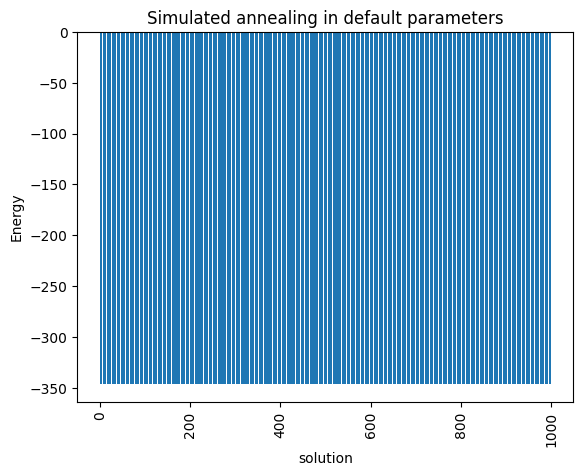

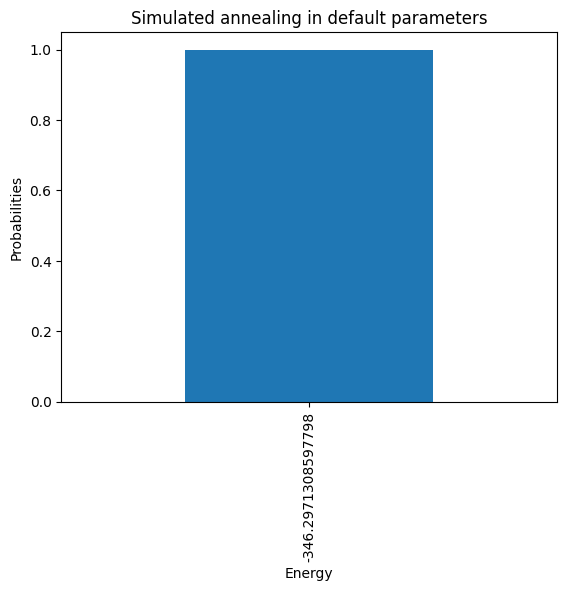

minimum energy: -346.2971308597798


{'beta_range': [0.03594618941052286, 297.4241884407982],
 'beta_schedule_type': 'geometric',
 'timing': {'preprocessing_ns': 8820914,
  'sampling_ns': 224567325,
  'postprocessing_ns': 324744}}

In [819]:
# Simulated Annealing

mod = bqm
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(mod, num_reads=1000)
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')
simAnnSamples.info

In [ ]:
plot_enumerate(exactSamples, title='Enumerate all solutions')
plot_energies(exactSamples, title='Enumerate all solutions', skip=10)

## Time To Solution (TTS):
We would like to obtain a large probability of finding a right solution (the definition of right comes from what you define as success). On the other hand, the time it takes to solve these cases should be as small as possible. Therefore we are interested in a metric that combines both, and is called the Time To Solution (TTS) which is defined as
$$
TTS = \frac{\log{1-s}}{\log{1-p}}
$$
where s is a success factor, usually takes as $s = 99\%$, and $p$ is the success probability, usually accounted as the observed success probability.

One usually reads this as the time to solution within 99\% probability.
